# Association Rule (Apriori Algorithm)

In [1]:
import numpy as np
import pandas as pd
from apyori import apriori
from mlxtend.frequent_patterns import apriori, association_rules 

In [2]:
df = pd.read_csv('supermarket_data.csv')

In [3]:
df.groupby(['CUST_CODE']).sum().sort_values(by=['SPEND'],ascending=False).reset_index()

,CUST_CODE,SHOP_DATE,SHOP_HOUR,BASKET_ID,QUANTITY,SPEND
0,CUST0000123240,50767181763,31783,2514098700921778688,12339,10149.73
1,CUST0000783041,41733300843,26378,2066750161496873472,6173,8045.70
2,CUST0000455778,54299832382,46409,2689061359143165952,4951,7164.68
3,CUST0000942162,57692834291,45337,2857066242532282368,3421,5528.45
4,CUST0000372422,39165518324,27217,1939504875791216384,3226,5156.49
5,CUST0000019927,46872908634,23126,2321242377520143872,5620,4978.21
6,CUST0000584369,24008354407,16738,1188952850248793856,2220,4738.41
7,CUST0000139111,36956319621,22853,1830152498670881536,2846,4677.48
8,CUST0000219191,38500472224,30788,1906698279589928704,2610,4421.78
9,CUST0000667911,17544416925,13214,868849982121913984,1501,4213.45


In [4]:
df.describe()

,SHOP_DATE,SHOP_HOUR,BASKET_ID,QUANTITY,SPEND
count,6.719140e+05,671914.000000,6.719140e+05,671914.000000,671914.000000
mean,2.007391e+07,14.745869,9.941078e+14,1.514344,1.852796
std,4.594496e+03,3.551738,2.286042e+09,1.668037,2.589564
min,2.007010e+07,8.000000,9.941039e+14,1.000000,0.010000
25%,2.007052e+07,12.000000,9.941058e+14,1.000000,0.750000
50%,2.007093e+07,15.000000,9.941077e+14,1.000000,1.210000
75%,2.008022e+07,17.000000,9.941098e+14,1.000000,2.040000
max,2.008071e+07,21.000000,9.941117e+14,73.000000,189.630000


In [5]:
basket = (df.groupby(['BASKET_ID', 'PROD_CODE'])['QUANTITY'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('BASKET_ID'))

In [6]:
def hot_encode(x): 
    if(x<= 0): 
        return 0
    if(x>= 1): 
        return 1

In [7]:
basket_encoded = basket.applymap(hot_encode) 
basket = basket_encoded


In [8]:
# Building the model 
frq_items = apriori(basket, min_support = 0.005, use_colnames = True) 
  
# Collecting the inferred rules in a dataframe 
rules = association_rules(frq_items, metric ="lift", min_threshold = 1) 
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
rules.head(5) 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
26,(PRD0900531),(PRD0903052),0.023883,0.161852,0.013447,0.563043,3.478754,0.009582,1.918150
122,"(PRD0904358, PRD0901265)",(PRD0903052),0.010924,0.161852,0.005420,0.496198,3.065749,0.003652,1.663645
20,(PRD0900239),(PRD0903052),0.014215,0.161852,0.006978,0.490869,3.032827,0.004677,1.646233
115,"(PRD0903678, PRD0901265)",(PRD0903052),0.014693,0.161852,0.007040,0.479152,2.960432,0.004662,1.609199
73,(PRD0903497),(PRD0903052),0.012409,0.161852,0.005316,0.428452,2.647182,0.003308,1.466452


# Customer Segmentation (RFM Analysis)

In [13]:
# import libraries
from __future__ import division
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [14]:
#Transform date to datetime
df['year'] = df['SHOP_DATE'].apply(lambda x : str(x)[0:4])
df['month'] = df['SHOP_DATE'].apply(lambda x : str(x)[4:6])
df['day'] = df['SHOP_DATE'].apply(lambda x : str(x)[6:8])
df['SHOP_DAY'] = pd.to_datetime(df[['year','month','day']])
df = df.drop(['year','month','day','SHOP_DATE'],axis=1)


In [15]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['CUST_CODE'].unique())
df_user.columns = ['CUST_CODE']

#get the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('CUST_CODE').SHOP_DAY.max().reset_index()
df_max_purchase.columns = ['CUST_CODE','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['CUST_CODE','Recency']], on='CUST_CODE')

df_user.head()

,CUST_CODE,Recency
0,CUST0000153531,274
1,CUST0000219191,8
2,CUST0000526979,0
3,CUST0000913709,14
4,CUST0000961285,13


In [16]:
df_user.Recency.describe()

count    4891.000000
mean      141.869147
std       157.094698
min         0.000000
25%        14.000000
50%        71.000000
75%       251.000000
max       552.000000
Name: Recency, dtype: float64

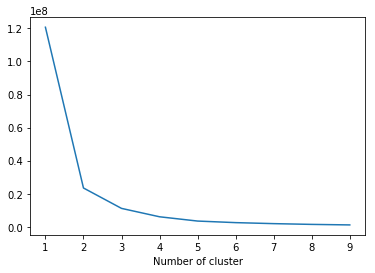

In [17]:
# Elbow method (checking number of clusters)
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [18]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

In [19]:
df_user.loc[0:2]

,CUST_CODE,Recency,RecencyCluster
0,CUST0000153531,274,2
1,CUST0000219191,8,0
2,CUST0000526979,0,0


In [20]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('CUST_CODE').SHOP_DAY.count().reset_index()
df_frequency.columns = ['CUST_CODE','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='CUST_CODE')

df_user.head()

,CUST_CODE,Recency,RecencyCluster,Frequency
0,CUST0000153531,274,2,1
1,CUST0000219191,8,0,1918
2,CUST0000526979,0,0,1124
3,CUST0000913709,14,0,531
4,CUST0000961285,13,0,118


In [21]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

In [22]:
#calculate revenue for each customer
df_revenue = df.groupby('CUST_CODE').SPEND.sum().reset_index()
df_revenue.columns = ['CUST_CODE','Revenue']
#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='CUST_CODE')

In [23]:
#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Revenue']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['Revenue']])

In [24]:
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Revenue'].median().sort_values(by=['Revenue'],ascending=False)

,Recency,Frequency,Revenue
OverallScore,,,
3,3.5,1043.0,1801.785
4,5.0,559.5,972.140
0,35.0,22.0,39.250
2,213.5,5.0,10.250
1,425.0,3.0,4.060
